In [1]:
import numpy as np
import math
import time
import random
import gym
from gym import spaces
from stable_baselines3 import A2C
import torch
from stable_baselines3.common.env_checker import check_env
import matplotlib.pyplot as plt

In [2]:
torch.__version__

'1.13.1'

In [3]:
gym.__version__

'0.21.0'

In [4]:
%matplotlib inline

## Utils

In [5]:
def alter_coord(action, position, g_coord, dx=0.1, change_nodes=list(range(1,9))):
        
    if action==0:
        g_coord[int(2*change_nodes[position])]+=dx
        g_coord[int(2*change_nodes[position])+1]+=dx
    elif action==1:
        g_coord[int(2*change_nodes[position])]+=dx
        g_coord[int(2*change_nodes[position])+1]-=dx
    if action==2:
        g_coord[int(2*change_nodes[position])]-=dx
        g_coord[int(2*change_nodes[position])+1]+=dx
    elif action==3:
        g_coord[int(2*change_nodes[position])]-=dx
        g_coord[int(2*change_nodes[position])+1]-=dx    
    elif action==4:
        g_coord[int(2*change_nodes[position])+1]-=0
             
    return g_coord

In [6]:
def observe(position, coord, displ):    
    return position, coord[0], coord[1],coord[2], coord[3], coord[4], coord[5],coord[6], \
coord[7], coord[8], coord[9],coord[10], coord[11], coord[12], coord[13],coord[14], coord[15],\
coord[16], coord[17],coord[18], coord[19], np.max(abs(displ))

In [7]:
def draw(coord,color,elcon):
    coord=coord.reshape(np.max(elcon)+1,2)
    plt.figure(figsize=(13,5))
    for item in elcon:
        plt.plot([coord[item[0]][0],coord[item[1]][0]],[coord[item[0]][1],coord[item[1]][1]],color=color)
       
    plt.show()  

In [8]:
def reward_(obs_,obs): 
    if obs_[-1]>obs[-1]:
        return 1
    else:
        return 0

## Finite Element Model of the Plane Frame structure

In [9]:
def PlaneFrameElementLength(x1,y1,x2,y2):
    return math.sqrt((x2-x1)*(x2-x1) + (y2-y1)*(y2-y1))+10e-9

In [10]:
def PlaneFrameElementStiffness(E,A,I,L,theta):
    pi=math.pi 
    x = theta*pi/180
    C = math.cos(x)
    S = math.sin(x)
    w1 = A*C*C + 12*I*S*S/(L*L)
    w2 = A*S*S + 12*I*C*C/(L*L)
    w3 = (A-12*I/(L*L))*C*S
    w4 = 6*I*S/L
    w5 = 6*I*C/L
    
    return E/L*np.array([[w1, w3, -w4, -w1, -w3, -w4],[ w3, w2, w5, -w3, -w2, w5],
                        [-w4, w5, 4*I, w4, -w5, 2*I],[ -w1, -w3, w4, w1, w3, w4],
                        [-w3, -w2, -w5, w3, w2, -w5], [-w4, w5, 2*I, w4, -w5, 4*I]])    

In [11]:
def PlaneFrameAssemble(K,k,i,j):
    K[3*i,3*i] = K[3*i,3*i] + k[0,0]
    K[3*i,3*i+1] = K[3*i,3*i+1] + k[0,1]    
    K[3*i,3*i+2] = K[3*i,3*i+2] + k[0,2]
    K[3*i,3*j] = K[3*i,3*j] + k[0,3]
    K[3*i,3*j+1] = K[3*i,3*j+1] + k[0,4]
    K[3*i,3*j+2] = K[3*i,3*j+2] + k[0,5]
    K[3*i+1,3*i] = K[3*i+1,3*i] + k[1,0]
    K[3*i+1,3*i+1] = K[3*i+1,3*i+1] + k[1,1]
    K[3*i+1,3*i+2] = K[3*i+1,3*i+2] + k[1,2]
    K[3*i+1,3*j] = K[3*i+1,3*j] + k[1,3]
    K[3*i+1,3*j+1] = K[3*i+1,3*j+1] + k[1,4]
    K[3*i+1,3*j+2] = K[3*i+1,3*j+2] + k[1,5]
    K[3*i+2,3*i] = K[3*i+2,3*i] + k[2,0]
    K[3*i+2,3*i+1] = K[3*i+2,3*i+1] + k[2,1]
    K[3*i+2,3*i+2] = K[3*i+2,3*i+2] + k[2,2]
    K[3*i+2,3*j] = K[3*i+2,3*j] + k[2,3]
    K[3*i+2,3*j+1] = K[3*i,3*j+1] + k[2,4]
    K[3*i+2,3*j+2] = K[3*i+2,3*j+2] + k[2,5]
    K[3*j,3*i] = K[3*j,3*i] + k[3,0]
    K[3*j,3*i+1] = K[3*j,3*i+1] + k[3,1]
    K[3*j,3*i+2] = K[3*j,3*i+2] + k[3,2]
    K[3*j,3*j] = K[3*j,3*j] + k[3,3]
    K[3*j,3*j+1] = K[3*j,3*j+1] + k[3,4]
    K[3*j,3*j+2] = K[3*j,3*j+2] + k[3,5]   
    K[3*j+1,3*i] = K[3*j+1,3*i] + k[4,0]
    K[3*j+1,3*i+1] = K[3*j+1,3*i+1] + k[4,1]
    K[3*j+1,3*i+2] = K[3*j+1,3*i+2] + k[4,2]
    K[3*j+1,3*j] = K[3*j+1,3*j] + k[4,3]
    K[3*j+1,3*j+1] = K[3*j+1,3*j+1] + k[4,4]
    K[3*j+1,3*j+2] = K[3*j+1,3*j+2] + k[4,5]
    K[3*j+2,3*i] = K[3*j+2,3*i] + k[5,0]
    K[3*j+2,3*i+1] = K[3*j+2,3*i+1] + k[5,1]
    K[3*j+2,3*i+2] = K[3*j+2,3*i+2] + k[5,2]
    K[3*j+2,3*j] = K[3*j+2,3*j] + k[5,3]
    K[3*j+2,3*j+1] = K[3*j+2,3*j+1] + k[5,4]
    K[3*j+2,3*j+2] = K[3*j+2,3*j+2] + k[5,5]
    
    return K

In [12]:
def FEA_u(coord, elcon, bc_node, bc_val, global_force, I=5e-5, A=2e-2, E=210e6):
    K=np.zeros(shape=(3*np.max(elcon)+3,3*np.max(elcon)+3))
    pi=math.pi
    for el in elcon:
        L=PlaneFrameElementLength(coord[el[0]][0],coord[el[0]][1],coord[el[1]][0],coord[el[1]][1])
        theta=math.atan((coord[el[1]][1]-coord[el[0]][1])/(coord[el[1]][0]-coord[el[0]][0]+1e-13))*180/pi
        k=PlaneFrameElementStiffness(E,A,I,L,theta)
        K=PlaneFrameAssemble(K,k,el[0],el[1])
    
    
    F = np.array(global_force)
    
    
    # https://github.com/CALFEM/calfem-matlab/blob/master/fem/solveq.m
    
    bc=np.array([bc_node, 
                bc_val]).T
    nd, nd=K.shape
    fdof=np.array([i for i in range(nd)]).T
    d=np.zeros(shape=(len(fdof),))
    Q=np.zeros(shape=(len(fdof),))

    pdof=bc[:,0].astype(int)
    dp=bc[:,1]
    fdof=np.delete(fdof, pdof, 0)
    
    K[np.isnan(K)] = 0
    F[np.isnan(F)] = 0
    
    s=np.linalg.lstsq(K[fdof,:][:,fdof], (F[fdof].T-np.dot(K[fdof,:][:,pdof],dp.T)).T, rcond=None)[0] 
    d[pdof]=dp
    d[fdof]=s.reshape(-1,)
    
#     Q=np.dot(K,d).T-F 
    return d

In [13]:
# 8 The Plane Frame Element - verification
d = FEA_u(np.array([0,0,
                    0,3,
                    4,3,
                    4,0]).reshape(4,2),
          elcon=np.array([[0, 1],
                      [1, 2],
                      [2, 3]]),
          bc_node=[0,1,2,9,10,11], 
          bc_val=[0,0,0,0,0,0], 
          global_force=[0,0,0,-20,0,0,0,0,12,0,0,0])

In [14]:
d

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -3.78670357e-03,
       -6.13322735e-06,  7.83082263e-04, -3.77926520e-03,  6.13322735e-06,
        1.40375402e-03,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

## Reinforcement learning model

In [15]:
N_DISCRETE_ACTIONS=5
DIM=22

In [16]:
class TrussEnv(gym.Env):
    
    metadata = {"render.modes": ["human"]}

    def __init__(self):
        super().__init__()
        self.action_space = spaces.Discrete(N_DISCRETE_ACTIONS)
        
        self.pst=random.randint(0,7)
        self.g_coord = alter_coord(4, self.pst, 
                                   np.array([0.0,0,3,0,6,0,9,0,9,3,9,6,9,9,12,9,15,9,18,9]),
                                   dx=0.1, 
                                   change_nodes=list(range(1,9)))
            
            
        self.displ = FEA_u(self.g_coord.reshape(10,2), 
                           elcon=np.array([[0,1],[1,2],[2,3],[3,4],[4,5],[5,6],[6,7],[7,8],[8,9]]),
                           bc_node=[0,1,2], 
                           bc_val=[0,0,0], 
                           global_force=np.array([0,0,0,
                                                  0,0,0,
                                                  0,0,0,
                                                  0,0,0,
                                                  0,0,0,
                                                  0,0,0,
                                                  0,0,0,
                                                  0,0,0,
                                                  0,0,0,
                                                  -10,0,0]))
        self.obs=observe(self.pst, self.g_coord, self.displ)
        self.observation_space = spaces.Box(low=np.array([-np.inf for x in range(DIM)]),
                                            high=np.array([np.inf for y in range(DIM)]),
                                            shape=(DIM,),
                                           dtype=np.float64)
        self.needs_reset = True

    def step(self, action):
        
        obs_=self.obs        
        self.g_coord = alter_coord(action, self.pst, self.g_coord,
                                  dx=0.1, change_nodes=list(range(1,9)))

        self.pst=random.randint(0,7)
        
        done =False
        if PlaneFrameElementLength(self.g_coord[0],
                                   self.g_coord[1],
                                   self.g_coord[2],
                                   self.g_coord[3])<0.02:
            done=True

        if PlaneFrameElementLength(self.g_coord[2],
                                   self.g_coord[3],
                                   self.g_coord[4],
                                   self.g_coord[5])<0.02:
            done=True

        if PlaneFrameElementLength(self.g_coord[4],
                                   self.g_coord[5],
                                   self.g_coord[6],
                                   self.g_coord[7])<0.02:
            done=True

        if PlaneFrameElementLength(self.g_coord[6],
                                   self.g_coord[7],
                                   self.g_coord[8],
                                   self.g_coord[9])<0.02:
            done=True

        if PlaneFrameElementLength(self.g_coord[8],
                                   self.g_coord[9],
                                   self.g_coord[10],
                                   self.g_coord[11])<0.02:
            done=True


        if PlaneFrameElementLength(self.g_coord[10],
                                   self.g_coord[11],
                                   self.g_coord[12],
                                   self.g_coord[13])<0.02:
            done=True

        if PlaneFrameElementLength(self.g_coord[12],
                                   self.g_coord[13],
                                   self.g_coord[14],
                                   self.g_coord[15])<0.02:
            done=True

        if PlaneFrameElementLength(self.g_coord[14],
                                   self.g_coord[15],
                                   self.g_coord[16],
                                   self.g_coord[17])<0.02:
            done=True

        if PlaneFrameElementLength(self.g_coord[16],
                                   self.g_coord[17],
                                   self.g_coord[18],
                                   self.g_coord[19])<0.02:
            done=True


        self.displ = FEA_u(self.g_coord.reshape(10,2), elcon=np.array([[0,1],[1,2],[2,3],[3,4],[4,5],[5,6],[6,7],[7,8],[8,9]]),
                                           bc_node=[0,1,2], 
                                           bc_val=[0,0,0], 
                                           global_force=np.array([0,0,0,
                                                  0,0,0,
                                                  0,0,0,
                                                  0,0,0,
                                                  0,0,0,
                                                  0,0,0,
                                                  0,0,0,
                                                  0,0,0,
                                                  0,0,0,
                                                  -10,0,0]))

        self.obs=observe(self.pst,self.g_coord,self.displ) 

        reward=reward_(obs_, self.obs)
        
        if self.needs_reset:
            raise RuntimeError("Tried to step environment that needs reset")
            
        if done:
            self.needs_reset = True
      
        return np.array(self.obs), reward, done, dict()

    def reset(self):
        self.pst=random.randint(0,7)
        self.g_coord = alter_coord(4, self.pst, np.array([0.0,0,3,0,6,0,9,0,9,3,9,6,9,9,12,9,15,9,18,9]),
                                          dx=0.1, change_nodes=list(range(1,9)))
            
            
        self.displ = FEA_u(self.g_coord.reshape(10,2), elcon=np.array([[0,1],[1,2],[2,3],[3,4],[4,5],[5,6],[6,7],[7,8],[8,9]]),
                                                    bc_node=[0,1,2], 
                                                    bc_val=[0,0,0], 
                                                    global_force=np.array([0,0,0,
                                                  0,0,0,
                                                  0,0,0,
                                                  0,0,0,
                                                  0,0,0,
                                                  0,0,0,
                                                  0,0,0,
                                                  0,0,0,
                                                  0,0,0,
                                                  -10,0,0]))
        self.obs=observe(self.pst, self.g_coord, self.displ)
        self.needs_reset = False
        return np.array(self.obs)  

    def render(self, mode="human"):
        draw(self.g_coord,
             color="blue",
             elcon=np.array([[0,1],[1,2],[2,3],[3,4],[4,5],[5,6],[6,7],[7,8],[8,9]]))

    def close(self):
        pass

In [17]:
env = TrussEnv()
check_env(env)

In [18]:
start=time.time()
model = A2C("MlpPolicy", env).learn(total_timesteps=2_000_000)
end=time.time()   

In [19]:
print('Total time taken: {} min'.format((end - start)/60))

Total time taken: 112.7925681511561 min


### Design by AI

In [20]:
obs = env.reset()

In [21]:
i=0
while i<50:
    action, _states = model.predict(obs)
    obs, rewards, dones, info = env.step(action)
    i+=1   

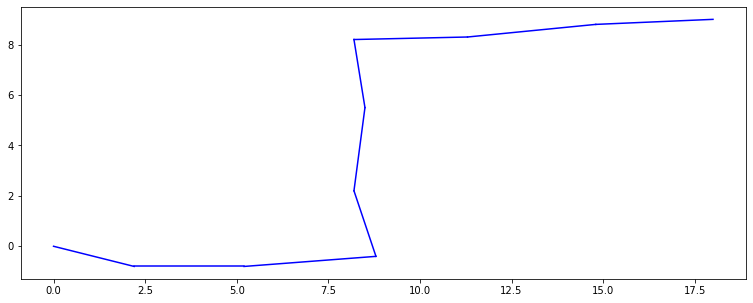

In [22]:
env.render() 

In [23]:
min(env.displ),max(env.displ)

(-0.18980919307769356, 0.1600698586290688)

### Initial Design 

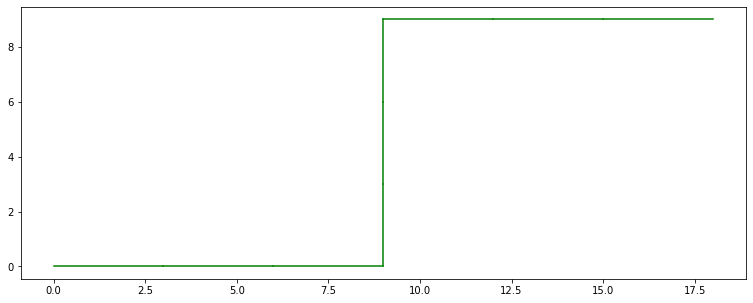

In [24]:
draw(np.array([0,0,3,0,6,0,9,0,9,3,9,6,9,9,12,9,15,9,18,9]),
     color="green",
     elcon=np.array([[0,1],[1,2],[2,3],[3,4],[4,5],[5,6],[6,7],[7,8],[8,9]]))

In [25]:
pst=random.randint(0,7)

In [26]:
g_coord = alter_coord(4, pst, np.array([0.0,0,3,0,6,0,9,0,9,3,9,6,9,9,12,9,15,9,18,9]),
                                          dx=0.1, change_nodes=list(range(1,9)))

In [27]:
dis=FEA_u(g_coord.reshape(10,2), elcon=np.array([[0,1],[1,2],[2,3],[3,4],[4,5],[5,6],[6,7],[7,8],[8,9]]),
                                                    bc_node=[0,1,2], 
                                                    bc_val=[0,0,0], 
                                        global_force=np.array([0,0,0,
                                                  0,0,0,
                                                  0,0,0,
                                                  0,0,0,
                                                  0,0,0,
                                                  0,0,0,
                                                  0,0,0,
                                                  0,0,0,
                                                  0,0,0,
                                                  -10,0,0]))

In [28]:
 min(dis), max(dis)

(-0.9257571525764527, 1.3885714431377043)